In [2]:
 !pip install pmdarima

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Libraries to define the required functions
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests


import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('C:\/Users/Admin/Documents/Kasia_Linux/during_combined_covid_short.csv')
df.head()

,date,TAoYW,Close
0,2021-04-01,105,390360.00
1,2021-04-02,83,391653.75
2,2021-04-03,62,392947.50
3,2021-04-04,67,394241.25
4,2021-04-05,127,395535.00


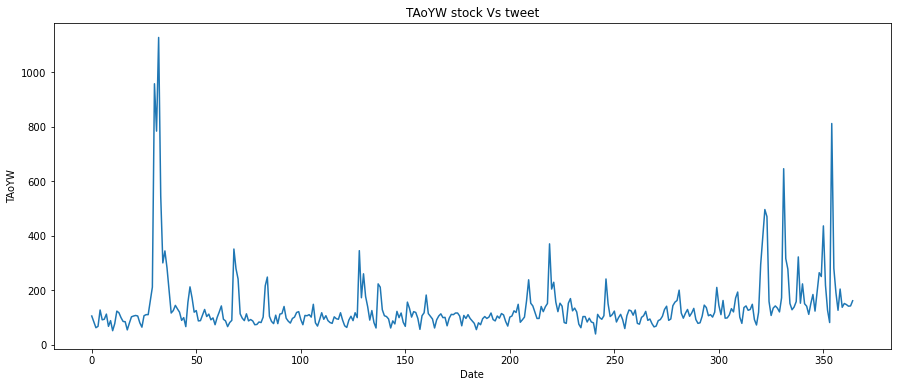

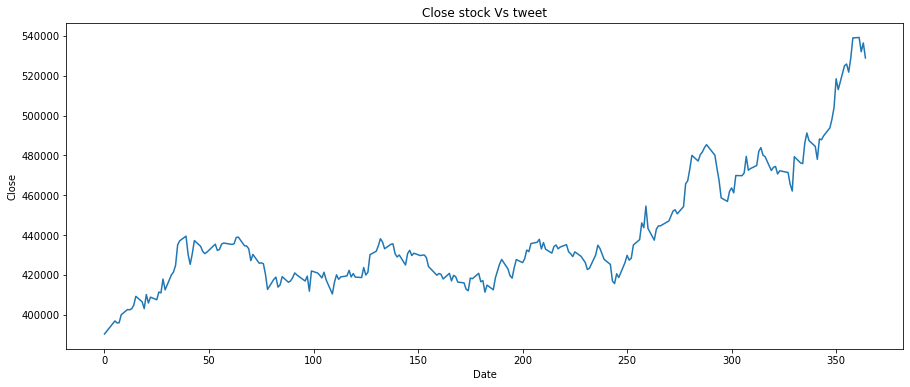

In [6]:
for feature in df[['TAoYW' ,'Close']]:
    df[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} stock Vs tweet")
    plt.show()

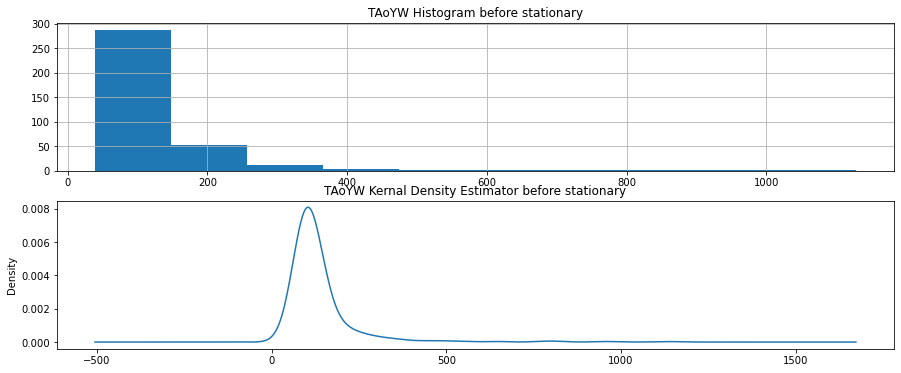

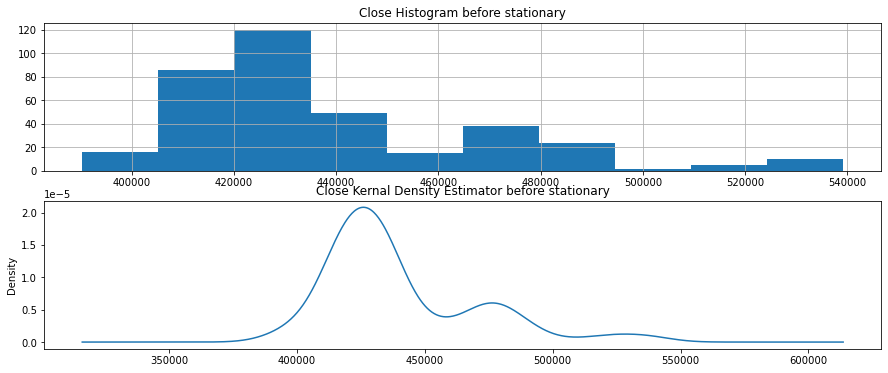

In [7]:
for feature in df[['TAoYW', 'Close']]:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{str(feature)} Histogram before stationary")
    df[str(feature)].hist()
    plt.subplot(212)
    df[str(feature)].plot(kind='kde')
    plt.title(f"{str(feature)} Kernal Density Estimator before stationary")
    plt.show()

In [ ]:
#Lag – the number of previous observations measured during autocorrelation.

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [13]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [14]:
def cointegration_test(df): 
    '''
    Test if there is a long-run relationship between features
    
    Args:
        dataframe (float64): Values of the columns to be checked, numpy array of floats 
    
    Returns:
        True or False whether a variable has a long-run relationship between other features
    ''' 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [15]:
def inverse_diff(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
''''Before applying the VAR model, all the time series variables in the data should be stationary. 
Stationarity is a statistical property in which time series show constant mean and variance over time.

One of the common methods to perform a stationarity check is the Augmented Dickey-Fuller test.

In the ADF test, there is a null hypothesis that the time series is considered non-stationary. 
So, if the p-value of the test is less than the significance level then it rejects the null hypothesis
and considers that the time series is stationary.''''

In [16]:
for name, column in df[['TAoYW','Close']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: TAoYW
Test Statistic                -6.621195e+00
p-value                        6.031096e-09
No Lags Used                   3.000000e+00
Number of Observations Used    3.610000e+02
Critical Value (1%)           -3.448595e+00
Critical Value (5%)           -2.869580e+00
Critical Value (10%)          -2.571053e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Close
Test Statistic                   0.301422
p-value                          0.977410
No Lags Used                     0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




In [ ]:
''''The Granger Causality test is used to determine whether or not one time series is useful for forecasting another.

This test uses the following null and alternative hypotheses:

Null Hypothesis (H0): Time series x does not Granger-cause time series y

Alternative Hypothesis (HA): Time series x Granger-causes time series y

The term “Granger-causes” means that knowing the value of time series x at a certain lag is useful
for predicting the value of time series y at a later time period.

This test produces an F test statistic with a corresponding p-value. If the p-value is less than a certain significance level 
(i.e. α = .05), then we can reject the null hypothesis and conclude that 
we have sufficient evidence to say that time series x Granger-causes time series y.'''

In [ ]:
'''''Granger causality test is used to determine if one time series will be useful to forecast another variable by investigating causality between two variables in a time series. The method is a probabilistic account of causality; 
it uses observed data sets to find patterns of correlation. One good thing about time series vector autoregression (VAR)
is that we could test ‘causality’ in some sense. This test is first proposed by Granger (1969),
and therefore we refer to it as the Granger causality.

Simple Mechanism to define Granger Causality:

It is based on the idea that if X causes Y, then the forecast of Y based on previous values of 
Y AND the previous values of X should best result in the forecast of Y based on previous values of Y alone.

Granger causality should not be used to test if a lag of Y causes Y. Instead, it is generally used on exogenous
(not Y lag) variables only. In simple terms ‘X is said to Granger-cause Y if Y 
can be better predicted using the histories of both X and Y than it can by using the history of Y alone’'''

In [ ]:
''''A lag features is a fancy name for a variable which contains data from prior time steps. 
If we have time-series data, we can convert it into rows.
Every row contains data about one observation and includes all previous occurrences of that observation.'''

In [5]:
print('TAoYW causes Close?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['Close','TAoYW']], 4)

print('\Close causes TAoYW ?\n')
print('------------------')
granger_2 = grangercausalitytests(df[[ 'TAoYW','Close']], 4)

TAoYW causes Close?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7972  , p=0.3725  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=0.8039  , p=0.3699  , df=1
likelihood ratio test: chi2=0.8030  , p=0.3702  , df=1
parameter F test:         F=0.7972  , p=0.3725  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8258  , p=0.4387  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=1.6746  , p=0.4329  , df=2
likelihood ratio test: chi2=1.6707  , p=0.4337  , df=2
parameter F test:         F=0.8258  , p=0.4387  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4808  , p=0.0161  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=10.6482 , p=0.0138  , df=3
likelihood ratio test: chi2=10.4946 , p=0.0148  , df=3
parameter F test:         F=3.4808  , p=0.0161  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr base

In [17]:
X = df[['TAoYW','Close']]

trainX, testX = time_train_test_split(X, test_size=30)

In [18]:
train_diff = trainX.diff()
train_diff.dropna(inplace = True)
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: TAoYW
Test Statistic                -8.081727e+00
p-value                        1.455328e-12
No Lags Used                   1.200000e+01
Number of Observations Used    3.210000e+02
Critical Value (1%)           -3.450887e+00
Critical Value (5%)           -2.870586e+00
Critical Value (10%)          -2.571590e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Close
Test Statistic                -1.852271e+01
p-value                        2.107756e-30
No Lags Used                   0.000000e+00
Number of Observations Used    3.330000e+02
Critical Value (1%)           -3.450141e+00
Critical Value (5%)           -2.870259e+00
Critical Value (10%)          -2.571415e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




In [1]:
for feature in train_diff:
    train_diff[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} stock Vs tweet after stationary")
    plt.show()

NameError: name 'train_diff' is not defined

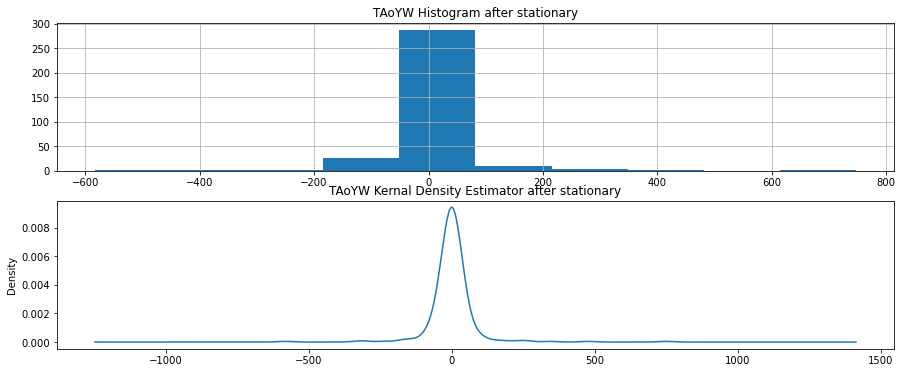

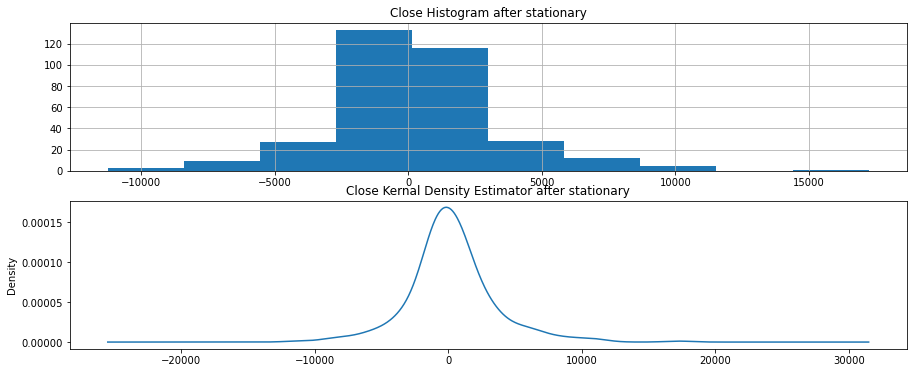

In [20]:
for feature in train_diff:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{str(feature)} Histogram after stationary")
    train_diff[str(feature)].hist()
    plt.subplot(212)
    train_diff[str(feature)].plot(kind='kde')
    plt.title(f"{str(feature)} Kernal Density Estimator after stationary")
    plt.show()

In [21]:
cointegration_test(train_diff)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
TAoYW  >  143.68    > 12.3212   =>   True
Close  >  48.98     > 4.1296    =>   True


In [ ]:
''''A cointegration test is the co-movement among underlying variables over the long run. 
This long-run estimation feature distinguishes it from correlation.
Two or more variables are cointegrated if ond only if they share common trends.
Cointegration helps to find out the statistical connection between two or more time series.
When two or more time series are cointegrated, they have a long run, statistically significant relationship'''

In [ ]:
''''A stationary time series is one whose properties do not depend on the time at which the series is observed.14 
Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will 
affect the value of the time series at different times. On the other hand, a white noise series is stationary
— it does not matter when you observe it, it should look much the same at any point in time.

#Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary.
This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where 
the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. 
Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.'''

In [22]:
resu = []
df_results_VAR = pd.DataFrame()

for i in [1,2,3,4,5,6,7,8,9]:
    fit_v = VAR(train_diff).fit(i)
    aic = fit_v.aic
    bic = fit_v.bic
    df1 = {'AR_Term':i, 'AIC': aic, 'BIC': bic}
    df_results_VAR = df_results_VAR.append(df1, ignore_index=True)
    clist = ['AR_Term','AIC','BIC']
    df_results_VAR = df_results_VAR[clist] 

In [ ]:
''''AIC stands for “Akaike Information Criterion”, and comes from minimizing the Kullback-Leibler divergence,
a statistical measure of how far are two distributions.BIC follows a similar principle, 
but stands for “Bayesian Information Criterion”.
The smaller the AIC the better. When is a model going to be
better? The larger the sample size, the lower the unexplained
variance, the fewer parameters we use'''

In [23]:
df_results_VAR.sort_values(by=['AIC', 'BIC'], ascending=True)

,AR_Term,AIC,BIC
3,4.0,24.953484,25.160707
7,8.0,24.967257,25.362210
2,3.0,24.967603,25.128417
4,5.0,24.970494,25.224334
6,7.0,24.972900,25.320602
0,1.0,24.986366,25.054982
5,6.0,24.987019,25.287685
8,9.0,24.991946,25.434362
1,2.0,25.002920,25.117532


In [24]:
best_values_VAR = df_results_VAR.sort_values(by=['AIC', 'BIC']).head(1)
best_values_VAR

,AR_Term,AIC,BIC
3,4.0,24.953484,25.160707


In [ ]:
#Vector Autoregression (VAR) is a stochastic process model utilized to seize the linear relation among the multiple variables
#of time-series data. VAR is a bidirectional model, while others are undirectional. 
#In a undirectionla model, a predictor influences the target variable, but not vice versa. 
#In a bidirectional model, variables influence each other.

In [ ]:
#Basic requirements to use the VAR model are :

#Time series with at least two variables.
#Relationship between variables.


#Steps that we need to follow to build the VAR model are:

#1. Examine the Data
#2. Test for stationarity
#2.1 If the data is non-stationary, take the difference.
#2.2 Repeat this process until you get the stationary data.
#3. Train Test Split
#4. Grid search for order P
#5. Apply the VAR model with order P
#6. Forecast on new data.
#7. If necessary, invert the earlier transformation.
#The basic difference between the ARIMA family and VAR models is that all the ARIMA models are used for univariate time series,
#where the VAR models work with multivariate time series. 
#In addition, ARIMA models are unidirectional models, 
#which means that the dependent variables are influenced by their past or lag values itself, 
#where VAR is a bi-directional model, which means a dependent variable is affected by its past value or by another variable’s
#value or influenced by both of the things. 

In [26]:
AR_Term_value_VAR = best_values_VAR['AR_Term'].iloc[0]

print("AR_Term_value_VAR: ", AR_Term_value_VAR)

AR_Term_value_VAR:  4.0


In [ ]:
#Vector autoregression (VAR) is a statistical model used to capture the relationship between multiple quantities as
#they change over time. VAR is a type of stochastic process model. 
#VAR models generalize the single-variable (univariate) autoregressive model by allowing for multivariate time series. 
#VAR models are often used in economics and the natural sciences.

#Like the autoregressive model, each variable has an equation modelling its evolution over time. 
#This equation includes the variable's
#lagged (past) values, the lagged values of the other variables in the model, and an error term.
#VAR models do not require as much knowledge about the forces influencing a variable as do structural models with simultaneous
#equations. The only prior knowledge required is a list of variables which can be hypothesized to affect each other over time.

In [ ]:
#How do we choose the number of lags in a VAR model?
#Lag selection is one of the important aspects of VAR model specification. In practical applications,
#we generally choose a maximum number of lags, , and evaluate the performance of the model including .

#The optimal model is then the model VAR(p) which minimizes some lag selection criteria. 
#The most commonly used lag selection criteria are:

#Akaike (AIC)
#Schwarz-Bayesian (BIC)

In [ ]:
''''To actually do the estimation, call the fit method with the desired lag order.
Or you can have the model select a lag order based on a standard information criterion
After this step, one thing comes up in the procedure: how to select the order.
One thing that is usually performed is to check for the best-fit lag value. 
We need to compare the different AIC(Akaike Information Criterion),  BIC(Bayesian Information criterion),
These all are the parameters that help to select the best-fit lag value.'''

In [27]:
model = VAR(train_diff)

results = model.fit(int(AR_Term_value_VAR))
display(results.summary())
z = results.forecast(y=train_diff.values, steps=len(testX))
df_pred = pd.DataFrame(z, columns=train_diff.columns)
df_pred["new_index"] = range(len(trainX), len(X))
df_pred = df_pred.set_index("new_index")
df_pred.head()
#correlation low

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Apr, 2022
Time:                     21:04:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    25.1607
Nobs:                     330.000    HQIC:                   25.0361
Log likelihood:          -5035.82    FPE:                6.87341e+10
AIC:                      24.9535    Det(Omega_mle):     6.51329e+10
--------------------------------------------------------------------
Results for equation TAoYW
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            1.093073         4.349770            0.251           0.802
L1.TAoYW        -0.199938         0.054787           -3.649           0.000
L1.Close         0.001197         0.001327            0.902           0.367
L2.T

,TAoYW,Close
new_index,,
335,15.583383,1121.285371
336,69.393444,-449.503879
337,23.518328,-109.969341
338,16.828948,-295.998338
339,-18.401334,323.931234


In [29]:
res = inverse_diff(df[['TAoYW','Close']],df_pred)
res.head()

,TAoYW,Close,TAoYW_1st_inv_diff,Close_1st_inv_diff
new_index,,,,
335,15.583383,1121.285371,176.583383,530042.285371
336,69.393444,-449.503879,245.976826,529592.781492
337,23.518328,-109.969341,269.495154,529482.812150
338,16.828948,-295.998338,286.324102,529186.813812
339,-18.401334,323.931234,267.922768,529510.745047


In [ ]:
#The inverse difference is the cumulative sum of the first value of the original series and the first differences
#Differencing is performed by subtracting the previous observation from the current observation.

In [32]:
for i in ['TAoYW' ,'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(testX[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for TAoYW
MSE is : 20881.826685830376
MAE is : 110.01230201330453
RMSE is : 144.5054555573262
MAPE is : 65.4811624135206
R2 is : -0.1659203607614359

Evaluation metric for Close
MSE is : 900484827.8766067
MAE is : 24614.256108107602
RMSE is : 30008.07937667132
MAPE is : 4.979847503369812
R2 is : -1.103806837487312



In [ ]:
''''R-squared (R2), which is the proportion of variation in the outcome that is explained by the predictor variables.
In multiple regression models, R2 corresponds to the squared correlation between the observed outcome values and
the predicted values by the model. The Higher the R-squared, the better the model.

Root Mean Squared Error (RMSE), which measures the average error performed by the model in predicting the outcome 
for an observation. Mathematically, the RMSE is the square root of the mean squared error (MSE), 
which is the average squared difference between the observed actual outome values and the values predicted by the model.
So, MSE = mean((observeds - predicteds)^2) and RMSE = sqrt(MSE). The lower the RMSE, the better the model.

Residual Standard Error (RSE), also known as the model sigma, is a variant of the RMSE adjusted for 
the number of predictors in the model. The lower the RSE, the better the model. 
In practice, the difference between RMSE and RSE is very small, particularly for large multivariate data.

Mean Absolute Error (MAE), like the RMSE, the MAE measures the prediction error. 
Mathematically, it is the average absolute difference between observed and predicted outcomes,
MAE = mean(abs(observeds - predicteds)). MAE is less sensitive to outliers compared to RMSE.'''

In [ ]:
''''The Mean absolute error represents the average of the absolute difference between the actual and
predicted values in the dataset. It measures the average of the residuals in the dataset.
#Mean Squared Error represents the average of the squared difference between the original and predicted values in the data set.
It measures the variance of the residuals.
#Root Mean Squared Error is the square root of Mean Squared error. It measures the standard deviation of residuals.
#The coefficient of determination or R-squared represents the proportion of the variance in the dependent variable
which is explained by the linear regression model. 
It is a scale-free score i.e. irrespective of the values being small or large, the value of R square will be less than one.
#Differences among these evaluation metrics
#Mean Squared Error(MSE) and Root Mean Square Error penalizes the large prediction errors vi-a-vis Mean Absolute Error (MAE).
However, RMSE is widely used than MSE to evaluate the performance of the regression model with other random models as
it has the same units as the dependent variable (Y-axis).
#MSE is a differentiable function that makes it easy to perform mathematical operations in comparison to
a non-differentiable function like MAE. Therefore, in many models, RMSE is used as a default metric for calculating
Loss Function despite being harder to interpret than MAE.

#The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model.
However, a higher value of R square is considered desirable.
#Both RMSE and R- Squared quantifies how well a linear regression model fits a dataset. 
The RMSE tells how well a regression model can predict the value of a response variable in absolute terms while
R- Squared tells how well the predictor variables can explain the variation in the response variable.'''

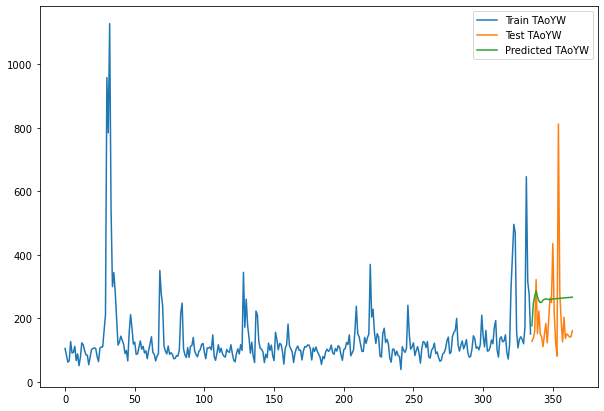

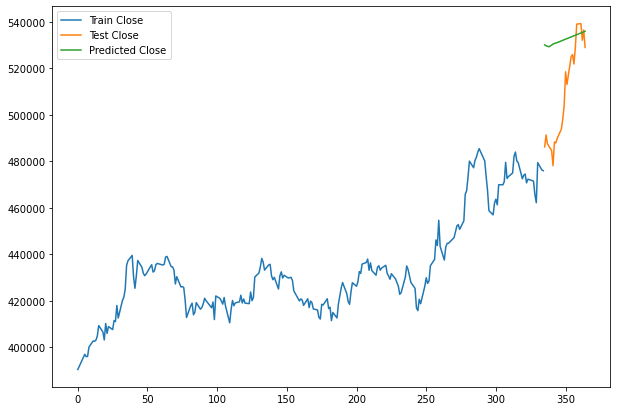

In [33]:
for i in ['TAoYW','Close' ]:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(trainX[str(i)], label='Train '+str(i))
    plt.plot(testX[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [34]:
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [ ]:
''''A VARMA model is another extension of the ARMA model for a multivariate time-series model that contains a
vector autoregressive (VAR) component, as well as the vector moving average (VMA). The method is used for 
multivariate time-series data deprived of trend and seasonal components.
#The Vector Autoregression Moving-Average (VARMA) method models the next step in each time series using an ARMA model.
It is the generalization of ARMA to multiple parallel time series, e.g. multivariate time series.

#The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to
a VARMA function, e.g. VARMA(p, q).
A VARMA model can also be used to develop VAR or VMA models.

#The method is suitable for multivariate time series without trend and seasonal components.'''

In [42]:
df_results_VARMA = pd.DataFrame(columns=['p', 'q', 'tr','RMSE open','RMSE high'])

for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(train_diff, order=(p,q), trend=tr).fit()
    z = model.forecast(y=train_diff[['TAoYW', 'Close']].values, steps=len(testX))
    df_pred = pd.DataFrame(z, columns=[ 'TAoYW', 'Close'])
    res = inverse_diff(df[['TAoYW', 'Close']],df_pred)
    openrmse = np.sqrt(metrics.mean_squared_error(testX.TAoYW, res.TAoYW_1st_inv_diff))
    highrmse = np.sqrt(metrics.mean_squared_error(testX.Close, res.Close_1st_inv_diff))
   # lowrmse = np.sqrt(metrics.mean_squared_error(testX.Low, res.Low_1st_inv_diff))
    #closermse = np.sqrt(metrics.mean_squared_error(testX.Close, res.Close_1st_inv_diff))
    df_results_VARMA = df_results_VARMA.append({'p': p, 'q': q, 'tr': tr,'RMSE open': openrmse,
                                                'RMSE high':highrmse }, ignore_index=True)

In [ ]:
#V for vector indicating that it’s a multivariate model

#AR for autoregression

#MA for moving average

#X for the use of exogenous variables (in addition to the endogenous variables)
#The VARMAX(p,q) model takes two hyperparameters:
#p for the order of the AR part

#q for the order of the MA part

#The time series in a VARMAX have to be stationary.

#trendstr{‘n’,’c’,’t’,’ct’} or iterable, optional
#Parameter controlling the deterministic trend polynomial .
#Can be specified as a string where ‘c’ indicates a constant (i.e. a degree zero component of the trend polynomial), 
#‘t’ indicates a linear trend with time, and ‘ct’ is both

In [ ]:
#It is an extension of VARMA model where extra variables called covariates are used to model the primary variable 
#we are interested it.
#Here we can see that the multivariate time series we are using are correlated. Now we can apply the Auto ARIMA model. 
#Which will tell us the order of p and q for our VARMA model.
#You can specify the param_grid parameter as a list of dictionaries, and ParameterGrid will generate 
#the disjoint union of the resulting grids.
#p: Stands for the number of lag observations included in the model, also known as the lag order.
#q: Is the size of the moving average window and also called the order of moving average.
#We can find an optimal set of parameters by checking the RMSE score after fitting them into the model. 
#The lower RMSE represents the best result

In [54]:
df_results_VARMA.sort_values(by=['RMSE open', 'RMSE high']).head()

,p,q,tr,RMSE open,RMSE high
24,3,1,n,133.496372,29128.787560
35,3,3,ct,134.047111,30206.571218
10,1,3,t,134.098731,30947.137487
1,1,1,c,134.275364,30250.388651
31,3,2,ct,134.647055,30155.008211


In [ ]:
# mean squared error (MSE) is a risk metric that measures the average of the squares of the prediction errors
#Squaring the errors means that values of MSE are always positive, and low values of MSE are highly desired.
#A perfect MSE score of 0 implies that our prediction powers are exactly aligned with actual values,
#and that the squares of such differences are negligible. While the application of both the MSE and MAE helps 
#determine the strength of our model's
#predictive powers, MSE triumphs over MAE by penalizing errors that are farther away from the mean. 
#Squaring the errors places a heavier bias on the risk metrics.
#In this image, I have sorted the data frame according to the lowest RMSE and we can see over here 
#that the best-fit combination of the parameters is (p = 3, q = 1, tr = n) because it gives the least RMSE values.

#Now we can fit these parameters on the model and predict the values. The below image is the evaluation metrics 
#for every time series in the multivariate time series.

In [55]:
best_values_VARMA = df_results_VARMA.sort_values(by=['RMSE open', 'RMSE high']).head(1)
best_values_VARMA

,p,q,tr,RMSE open,RMSE high
24,3,1,n,133.496372,29128.78756


In [56]:
p_value_VARMA = best_values_VARMA['p'].iloc[0]
q_value_VARMA = best_values_VARMA['q'].iloc[0] 
tr_value_VARMA = best_values_VARMA['tr'].iloc[0] 

print("p_value_VARMA: ", p_value_VARMA)
print("q_value_VARMA: ", q_value_VARMA)
print("tr_value_VARMA: ", tr_value_VARMA)

p_value_VARMA:  3
q_value_VARMA:  1
tr_value_VARMA:  n


In [57]:
model = VARMAX(train_diff[['TAoYW', 'Close']], 
               order=(p_value_VARMA, q_value_VARMA),trends = tr_value_VARMA).fit(disp=False)
result = model.forecast(steps = len(testX))

In [58]:
res = inverse_diff(df[['TAoYW', 'Close']], result)

res.head()

,TAoYW,Close,TAoYW_1st_inv_diff,Close_1st_inv_diff
334,5.134775,-797.115550,166.134775,528123.884450
335,-4.274609,253.872651,161.860166,528377.757101
336,35.804881,-268.382299,197.665047,528109.374802
337,19.687100,217.056831,217.352147,528326.431633
338,20.004055,154.554096,237.356202,528480.985729


In [59]:
for i in ['TAoYW', 'Close']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(testX[str(i)] , res[str(i)+'_1st_inv_diff'])


Evaluation metric for TAoYW
MSE is : 18349.376803703988
MAE is : 90.94039607246135
RMSE is : 135.4598715624077
MAPE is : 49.74859659511199
R2 is : -0.024523014418043276

Evaluation metric for Close
MSE is : 852766008.4456692
MAE is : 23955.927022956555
RMSE is : 29202.157599151287
MAPE is : 4.846356678722186
R2 is : -0.9923211405740648



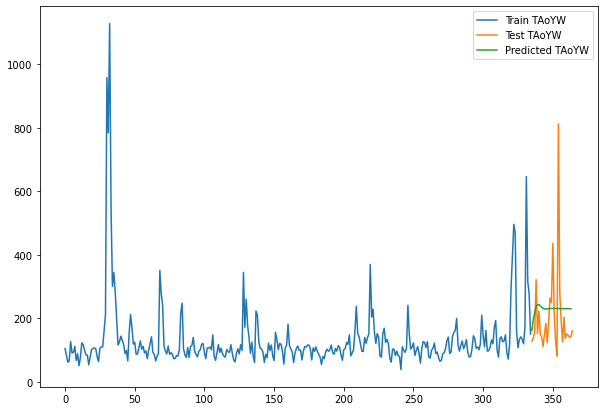

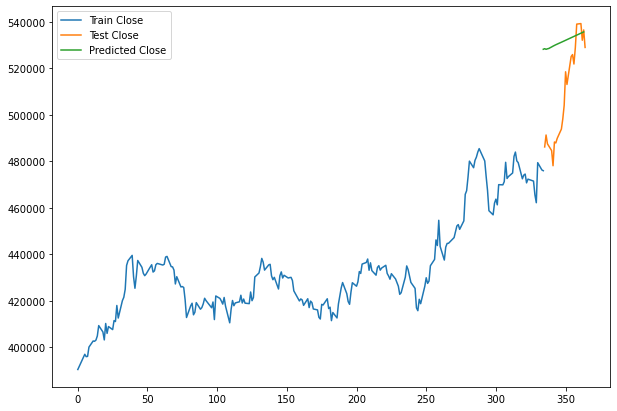

In [61]:
for i in ['TAoYW' ,'Close']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(trainX[str(i)], label='Train '+str(i))
    plt.plot(testX[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [ ]:
''''ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ 
a given time series based on its own past values, that is, its own lags and the lagged forecast errors, 
so that equation can be used to forecast future values.
#In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series:
seasonality, trend, and noise. These parameters are labeled p,d,and q.
#p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain 
tomorrow as well.
#d is the parameter associated with the integrated part of the model, which effects the amount of differencing to 
apply to a time series. You can imagine an example of this as forecasting that the amount of rain tomorrow 
will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.
#q is the parameter associated with the moving average part of the model.
#ARIMA has three components – AR (autoregressive term), I (differencing term) and MA (moving average term). 
Let us understand each of these components –

#AR term refers to the past values used for forecasting the next value. 
The AR term is defined by the parameter ‘p’ in arima. The value of ‘p’ is determined using the PACF plot.
#MA term is used to defines number of past forecast errors used to predict the future values. 
The parameter ‘q’ in arima represents the MA term. ACF plot is used to identify the correct ‘q’ value.
#Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary.
Test like ADF and KPSS can be used to determine whether the series is stationary and help in identifying the d value.
# Auto ARIMA takes into account the AIC and BIC values generated (as you can see in the code) 
to determine the best combination of parameters. AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion)
values are estimators to compare models. The lower these values, the better is the model'''

In [62]:
pq = []
for name, column in train_diff[['TAoYW', 'Close']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : TAoYW
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3883.401, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3896.458, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3886.213, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3887.139, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3885.345, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3889.118, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3886.634, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3885.398, Time=0.06 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.792 seconds
optimal order for:TAoYW is: (1, 0, 1) 


Searching order of p and q for : Close
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6354.447, Time=0.09 sec
 A

In [64]:
df_results_VARMA_2 = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High'])

for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[['TAoYW', 'Close']], order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(testX))
        inv_res = inverse_diff(df[['TAoYW', 'Close']], result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(testX['TAoYW'], inv_res.TAoYW_1st_inv_diff))
        Highrmse = np.sqrt(metrics.mean_squared_error(testX['Close'], inv_res.Close_1st_inv_diff))
        #Lowrmse = np.sqrt(metrics.mean_squared_error(testX['Low'], inv_res.Low_1st_inv_diff))
        #Closermse = np.sqrt(metrics.mean_squared_error(testX['Close'], inv_res.Close_1st_inv_diff))
        df_results_VARMA_2 = df_results_VARMA_2.append({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse,
                                                        'RMSE High':Highrmse }, ignore_index=True)

 Running for (1, 0, 1)


In [65]:
df_results_VARMA_2.sort_values(by=['RMSE Open', 'RMSE High'])

,p,q,RMSE Open,RMSE High
0,1.0,1.0,134.275364,30250.388651


In [68]:
best_values_VAR_2 = df_results_VARMA_2.sort_values(by=['RMSE Open', 'RMSE High' 
                                                       ]).head(1)
best_values_VAR_2

,p,q,RMSE Open,RMSE High
0,1.0,1.0,134.275364,30250.388651


In [69]:
p_value_VARMA_2 = best_values_VAR_2['p'].iloc[0]
q_value_VARMA_2 = best_values_VAR_2['q'].iloc[0] 

print("p_value_VARMA_2: ", p_value_VARMA_2)
print("q_value_VARMA_2: ", q_value_VARMA_2)

p_value_VARMA_2:  1.0
q_value_VARMA_2:  1.0


In [70]:
model = VARMAX(train_diff[['TAoYW', 'Close']], 
               order=(int(p_value_VARMA_2),int(q_value_VARMA_2))).fit(disp=False)
result = model.forecast(steps = len(testX))

In [72]:
res = inverse_diff(df[['TAoYW', 'Close' ]],result)
res.head()

,TAoYW,Close,TAoYW_1st_inv_diff,Close_1st_inv_diff
334,41.084809,190.734249,202.084809,529111.734249
335,-25.564184,291.600442,176.520625,529403.334690
336,17.408609,227.120982,193.929234,529630.455673
337,-10.296176,268.675729,183.633058,529899.131402
338,7.565175,241.885702,191.198233,530141.017104


In [73]:
for i in ['TAoYW', 'Close']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(testX[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for TAoYW
MSE is : 18029.873380162826
MAE is : 77.80217223743581
RMSE is : 134.27536401053928
MAPE is : 37.39125968107928
R2 is : -0.0066837921869538075

Evaluation metric for Close
MSE is : 915086013.5396631
MAE is : 24834.33415720804
RMSE is : 30250.38865105146
MAPE is : 5.024216060999726
R2 is : -1.137919654585846



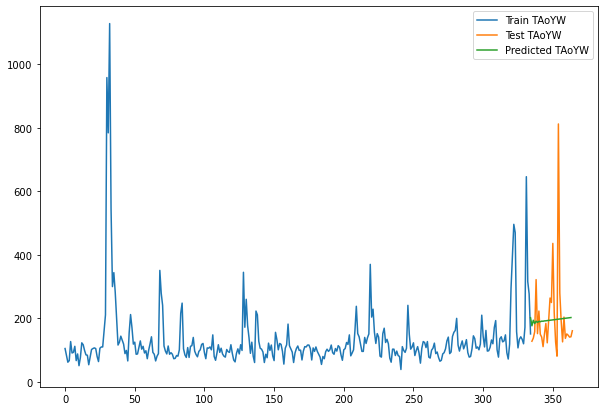

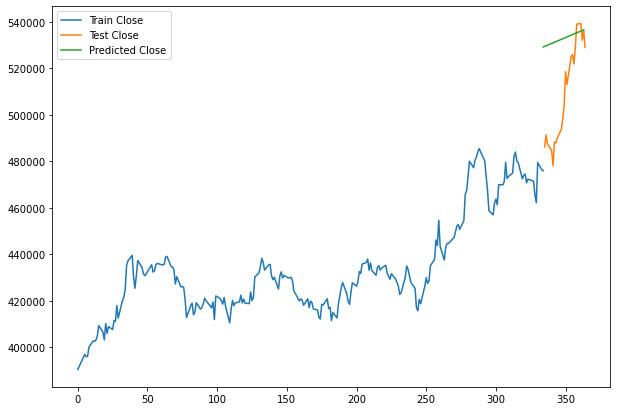

In [74]:
for i in ['TAoYW', 'Close' ]:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(trainX[str(i)], label='Train '+str(i))
    plt.plot(testX[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()